In [1]:
!pip install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 20.4 MB/s eta 0:00:00


In [2]:
import koreanize_matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import numpy as np
from IPython.display import display
import matplotlib.colors as mcolors
# import matplotlib.font_manager as fm

제주의 전기차 충전소 데이터를 가지고 총 5가지의 차트를 시각화했습니다.<br>
분석에는 2021년 6월부터 2022년 5월까지의 가장 최근 수집 가능한 데이터를 사용하였습니다.

<br>

1. 충전소 위치 지도

- 설명: 제주도 내 전기차 충전소의 지리적 분포를 보여주는 지도입니다.

- 특징: 일반 충전소와 상위 10개 충전소를 구분하여 표시하였습니다.

<br>

2. 상위 10개 충전소 정보 (표)

- 설명: 상위 10개 충전소의 상세 정보를 표 형식으로 제공합니다.

- 특징: 충전소 이름, 충전기 유형, 주소, 충전 횟수, 충전 시간, 충전량 및 각 지표의 전체 평균 대비 비율을 포함합니다.

<br>

3. 상위 10개 충전소 사용 비율 (도넛 차트)

- 설명: 전체 충전소 대비 상위 10개 충전소의 사용 비율을 나타냅니다.

- 특징: 전체 충전소 대비 충전 횟수, 충전 시간, 충전량에 대한 비율을 각각 보여줍니다.

<br>

4. 상위 10개 충전소 성능 비교 (막대 그래프)

- 설명: 상위 10개 충전소의 충전 횟수, 충전 시간, 충전량을 비교합니다.

- 특징: 각 지표별로 충전소를 내림차순으로 정렬하여 표시하였습니다.

<br>

5. 충전기 유형별 통계 (막대 그래프)

- 설명: 급속 충전기와 완속 충전기의 성능을 비교합니다.

- 특징: 충전기 수, 충전 횟수, 충전 시간, 충전량에 대한 통계를 보여줍니다.

In [3]:
def get_charger_type(charger_type):
    if charger_type in ['DC콤보', 'AC급속3상', 'DC차데모', 'DC차데모+AC3상+DC콤보', 'DC콤보2(버스충전기용)', 'DC차데모+AC3상']:
        return '급속'
    elif charger_type == '완속':
        return '완속'
    else:
        return '알 수 없음'

def analyze_regional_usage(df_charging):
    # 데이터 전처리
    df_charging['위도'] = pd.to_numeric(df_charging['위도'], errors='coerce')
    df_charging['경도'] = pd.to_numeric(df_charging['경도'], errors='coerce')
    df_charging['충전기 유형'] = df_charging['충전기 타입'].apply(get_charger_type)

    # 충전소별 이용률 계산 (충전소 ID와 이름으로 그룹화)
    station_usage = df_charging.groupby(['충전소 아이디', '충전소 이름']).agg({
        '위도': 'first',
        '경도': 'first',
        '충전 횟수': 'sum',
        '충전 시간(hrs)': 'sum',
        '충전량': 'sum',
        '충전기 타입': 'first',
        '충전기 유형': 'first',
        '주소': 'first'
    }).reset_index()

    # NaN 값이 있는 행 제거
    station_usage = station_usage.dropna(subset=['위도', '경도'])

    # 이용률 점수 계산 (각 지표의 정규화된 값의 합)
    station_usage['이용률 점수'] = (
        station_usage['충전 횟수'] / station_usage['충전 횟수'].max() +
        station_usage['충전 시간(hrs)'] / station_usage['충전 시간(hrs)'].max() +
        station_usage['충전량'] / station_usage['충전량'].max()
    )

    # 상위 10개 충전소 선택 및 인덱스 초기화
    top_10_stations = station_usage.nlargest(10, '이용률 점수').reset_index(drop=True)

    # 새로운 '순위' 열 추가
    top_10_stations['순위'] = top_10_stations.index + 1

    return station_usage, top_10_stations

def create_map(station_usage, top_10_stations):
    m = folium.Map(location=[33.3616, 126.5292], zoom_start=10)
    marker_cluster = MarkerCluster().add_to(m)

    for idx, row in station_usage.iterrows():
        folium.Marker(
            location=[row['위도'], row['경도']],
            popup=f"""
            <b>{row['충전소 이름']}</b><br>
            충전기 유형: {row['충전기 유형']}<br>
            충전기 타입: {row['충전기 타입']}<br>
            충전 횟수: {row['충전 횟수']}<br>
            충전 시간: {row['충전 시간(hrs)']:.2f} 시간<br>
            충전량: {row['충전량']:.2f}
            """,
            tooltip=f"충전소 이름: {row['충전소 이름']}<br>충전기 유형: {row['충전기 유형']}<br>충전기 타입: {row['충전기 타입']}"
        ).add_to(marker_cluster)

    for _, row in top_10_stations.iterrows():
        folium.Marker(
            location=[row['위도'], row['경도']],
            popup=f"""
            <b>{row['충전소 이름']} (이용률 {row['순위']}위)</b><br>
            충전기 유형: {row['충전기 유형']}<br>
            충전기 타입: {row['충전기 타입']}<br>
            충전 횟수: {row['충전 횟수']}<br>
            충전 시간: {row['충전 시간(hrs)']:.2f} 시간<br>
            충전량: {row['충전량']:.2f}<br>
            이용률 점수: {row['이용률 점수']:.2f}
            """,
            tooltip=f"이용률 {row['순위']}위: {row['충전소 이름']}<br>충전기 유형: {row['충전기 유형']}<br>충전기 타입: {row['충전기 타입']}",
            icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(m)

    return m

def plot_top_10_stats(top_10_usage, total_usage):
    metrics = ['충전 횟수', '충전 시간(hrs)', '충전량']
    top_10_percentages = [(top_10_usage[metric] / total_usage[metric]) * 100 for metric in metrics]
    remaining_percentages = [100 - percentage for percentage in top_10_percentages]

    colors = ['#ff9999', '#66b3ff', '#99ff99']
    remaining_colors = ['#ffcccc', '#cce6ff', '#ccffcc']

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    axes = [ax1, ax2, ax3]

    for i, (metric, top_10_pct, remaining_pct) in enumerate(zip(metrics, top_10_percentages, remaining_percentages)):
        axes[i].pie([top_10_pct, remaining_pct], colors=[colors[i], remaining_colors[i]],
                    autopct='%1.1f%%', startangle=90, pctdistance=0.85,
                    wedgeprops=dict(width=0.3, edgecolor='white'))
        axes[i].text(0, 0, metric, ha='center', va='center', fontsize=12, fontweight='bold')
        axes[i].set_title(f'상위 10개 충전소의 {metric} 비율', fontsize=14)

    plt.tight_layout()
    plt.show()


def plot_top_10_bar_charts(top_10_stations):
    fig, axes = plt.subplots(3, 1, figsize=(14, 20))

    metrics = ['충전 횟수', '충전 시간(hrs)', '충전량']
    pastel_colors = ['#FF9999', '#66B2FF', '#99FF99']  # 빨강, 파랑, 초록 계열의 파스텔 톤

    for i, metric in enumerate(metrics):
        # 데이터 정렬
        sorted_data = top_10_stations.sort_values(by=metric, ascending=True)

        # 그라데이션 색상 생성
        color = pastel_colors[i]
        n_colors = len(sorted_data)
        color_range = [mcolors.hex2color(color) + (alpha,) for alpha in np.linspace(0.3, 1, n_colors)]

        # 막대 그래프 생성
        bars = axes[i].barh(range(len(sorted_data)), sorted_data[metric], color=color_range)

        # y축 레이블 설정
        axes[i].set_yticks(range(len(sorted_data)))
        axes[i].set_yticklabels(sorted_data['충전소 이름'])

        axes[i].set_title(f'상위 10개 충전소 {metric}', fontsize=16)
        axes[i].set_xlabel(f'{metric} (합계)', fontsize=12)
        axes[i].set_ylabel('충전소 이름', fontsize=12)

        # x축 눈금 설정
        # axes[i].tick_params(axis='x', rotation=45)

        # 그리드 추가
        # axes[i].grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def plot_charger_type_stats(charger_type_stats):
    # '알 수 없음' 유형 제외
    charger_type_stats = charger_type_stats[charger_type_stats.index != '알 수 없음']

    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    pastel_colors = ['#FF9999', '#66B2FF']

    metrics = ['충전기 수', '충전 횟수', '충전 시간(hrs)', '충전량']

    for i, metric in enumerate(metrics):
        ax = axes[i // 2, i % 2]
        bars = sns.barplot(x=charger_type_stats.index, y=metric, data=charger_type_stats, palette=pastel_colors, ax=ax)
        ax.set_title(f'충전기 유형별 {metric}', fontsize=16)
        ax.set_xlabel('충전기 유형', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)

        ax.tick_params(axis='x', rotation=0)

        # 각 막대 위에 값 표시
        for bar in bars.patches:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:,.0f}',
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

def create_top_10_info(top_10_stations, total_usage, total_stations):
    top_10_info = top_10_stations[['충전소 이름', '충전기 유형', '충전기 타입', '주소', '충전 횟수', '충전 시간(hrs)', '충전량']]

    # 증감 비율 계산 함수
    def calculate_percentage(value, total, count):
        average = total / count
        percentage = ((value / average) - 1) * 100
        return f"▲{percentage:.2f}%" if percentage > 0 else f"▼{abs(percentage):.2f}%"

    # 증감 비율 열 추가
    top_10_info['충전 횟수 비율'] = top_10_info['충전 횟수'].apply(lambda x: calculate_percentage(x, total_usage['충전 횟수'], total_stations))
    top_10_info['충전 시간 비율'] = top_10_info['충전 시간(hrs)'].apply(lambda x: calculate_percentage(x, total_usage['충전 시간(hrs)'], total_stations))
    top_10_info['충전량 비율'] = top_10_info['충전량'].apply(lambda x: calculate_percentage(x, total_usage['충전량'], total_stations))

    return top_10_info

In [4]:
# CSV 파일에서 데이터 읽기
df_charging = pd.read_csv('df_charging.csv')

# 데이터 분석 실행
station_usage, top_10_stations = analyze_regional_usage(df_charging)

In [5]:
# 지도 시각화
m = create_map(station_usage, top_10_stations)
display(m)

In [6]:
# 상위 10개 충전소 통계 계산
top_10_usage = top_10_stations[['충전 횟수', '충전 시간(hrs)', '충전량']].sum()
total_usage = station_usage[['충전 횟수', '충전 시간(hrs)', '충전량']].sum()

# 상위 10개 충전소 정보 데이터프레임 생성
total_stations = len(station_usage)

# 상위 10개 충전소 통계 계산
top_10_usage = top_10_stations[['충전 횟수', '충전 시간(hrs)', '충전량']].sum()
total_usage = station_usage[['충전 횟수', '충전 시간(hrs)', '충전량']].sum()

# 상위 10개 충전소 정보 데이터프레임 생성
top_10_info = create_top_10_info(top_10_stations, total_usage, total_stations)

# 상위 10개 충전소 정보 데이터프레임 출력
top_10_info

<ipython-input-3-b605bc0cd013>:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_info['충전 횟수 비율'] = top_10_info['충전 횟수'].apply(lambda x: calculate_percentage(x, total_usage['충전 횟수'], total_stations))
<ipython-input-3-b605bc0cd013>:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_info['충전 시간 비율'] = top_10_info['충전 시간(hrs)'].apply(lambda x: calculate_percentage(x, total_usage['충전 시간(hrs)'], total_stations))
<ipython-input-3-b605bc0cd013>:178: SettingWithCopyWarning: 
A value is trying to be s

,충전소 이름,충전기 유형,충전기 타입,주소,충전 횟수,충전 시간(hrs),충전량,충전 횟수 비율,충전 시간 비율,충전량 비율
0,함덕회차지,급속,DC콤보2(버스충전기용),제주특별자치도 제주시 조천읍 함덕리 317-9,35468,13491.392222,1214931.37,▲1903.24%,▲984.72%,▲3805.32%
1,제주시청,급속,AC급속3상,제주특별자치도 제주시 이도이동 1176-1,21705,15625.280833,274651.44,▲1125.91%,▲1156.29%,▲782.85%
2,제주특별자치도청,알 수 없음,Unknown,제주특별자치도 제주시 연동 312-1,22230,9671.897500,283104.45,▲1155.56%,▲677.63%,▲810.02%
3,국제부두회차지,급속,DC콤보2(버스충전기용),제주특별자치도 제주시 건입동 1451-5,16138,6950.476389,690108.25,▲811.48%,▲458.83%,▲2118.31%
4,도청 제2청사 후문주차장,급속,AC급속3상,제주특별자치도 제주시 연동 322-8,10002,15393.197222,163785.58,▲464.92%,▲1137.63%,▲426.48%
5,제주시공영버스차고지,급속,DC콤보2(버스충전기용),제주특별자치도 제주시 노형동 568,14767,6265.086111,671931.00,▲734.05%,▲403.72%,▲2059.88%
6,모로왓제2공영주차장,급속,AC급속3상,제주특별자치도 제주시 일도이동 510,10312,13495.451944,185798.04,▲482.43%,▲985.05%,▲497.24%
7,서귀포시청,급속,AC급속3상,제주특별자치도 서귀포시 서홍동 440-1,12135,10132.771945,145190.76,▲585.39%,▲714.69%,▲366.71%
8,서귀포 제2청사,급속,AC급속3상,제주특별자치도 서귀포시 법환동 731,8137,12101.350000,121664.75,▲359.58%,▲872.96%,▲291.08%
9,삼양회차지,급속,DC콤보2(버스충전기용),제주특별자치도 제주시 삼양일동 1579-1,11394,5273.531667,466334.54,▲543.54%,▲324.00%,▲1399.00%


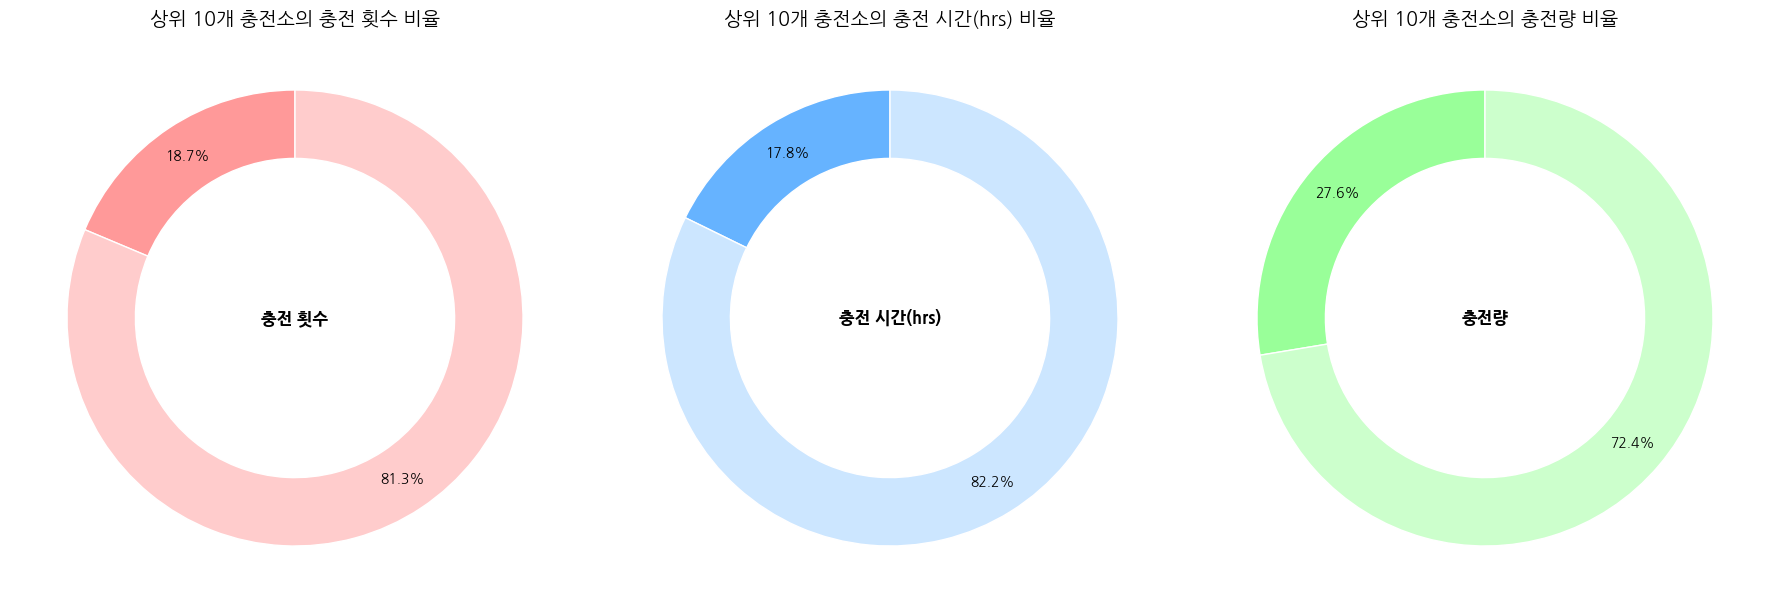

In [7]:
# 도넛 차트 출력
plot_top_10_stats(top_10_usage, total_usage)

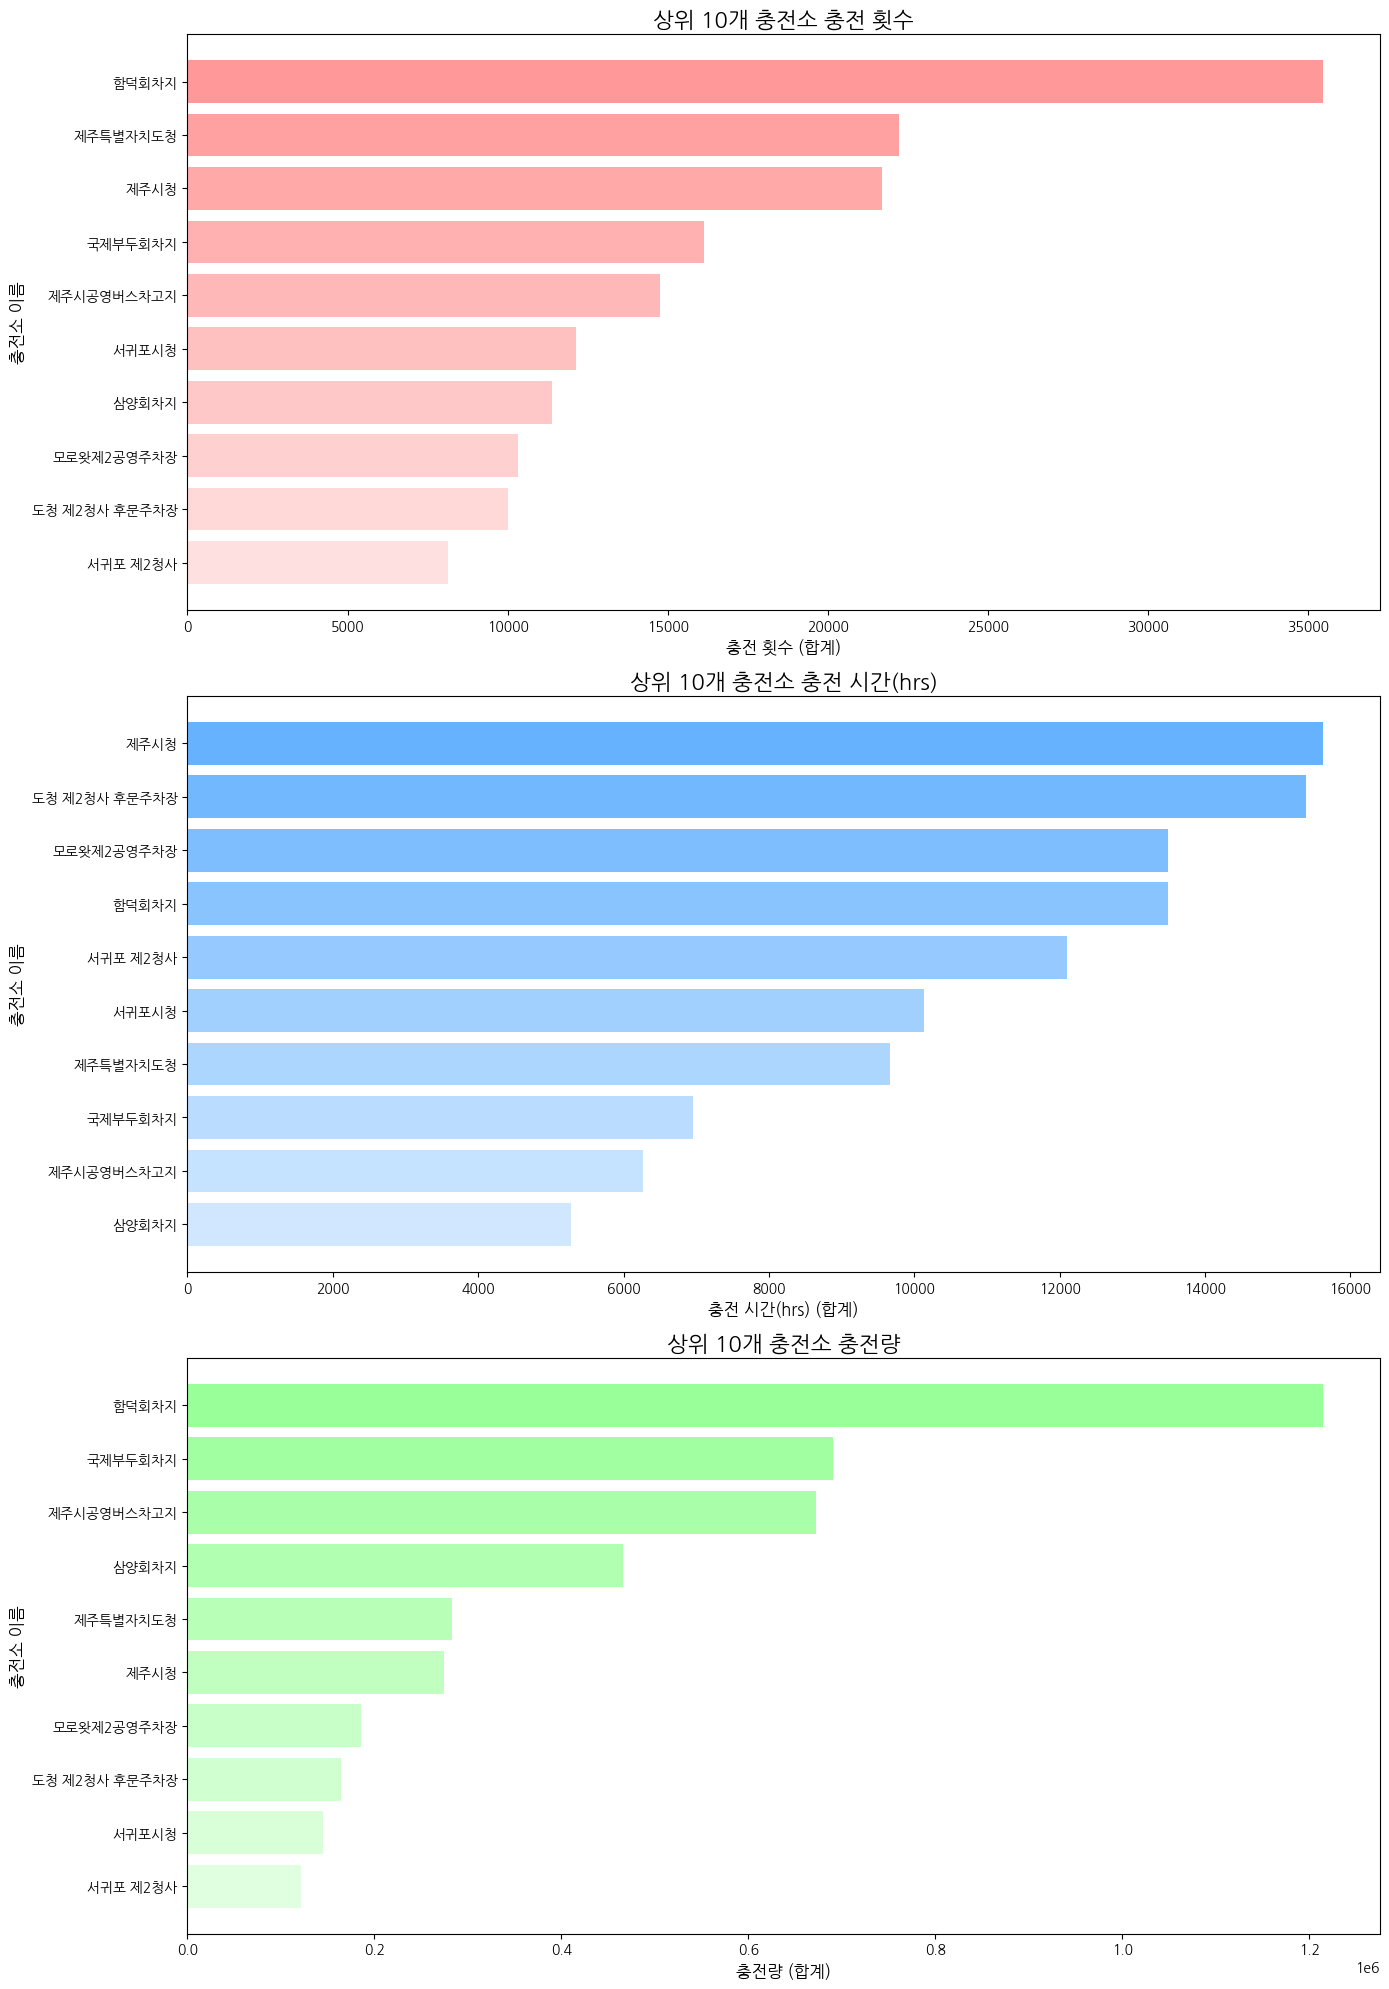

In [8]:
# 상위 10개 충전소 막대 그래프 출력
plot_top_10_bar_charts(top_10_stations)

<ipython-input-3-b605bc0cd013>:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=charger_type_stats.index, y=metric, data=charger_type_stats, palette=pastel_colors, ax=ax)
<ipython-input-3-b605bc0cd013>:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=charger_type_stats.index, y=metric, data=charger_type_stats, palette=pastel_colors, ax=ax)
<ipython-input-3-b605bc0cd013>:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=charger_type_stats.index, y=metric, data=charger_type_stats, palette=pastel_colors, ax=ax)
<

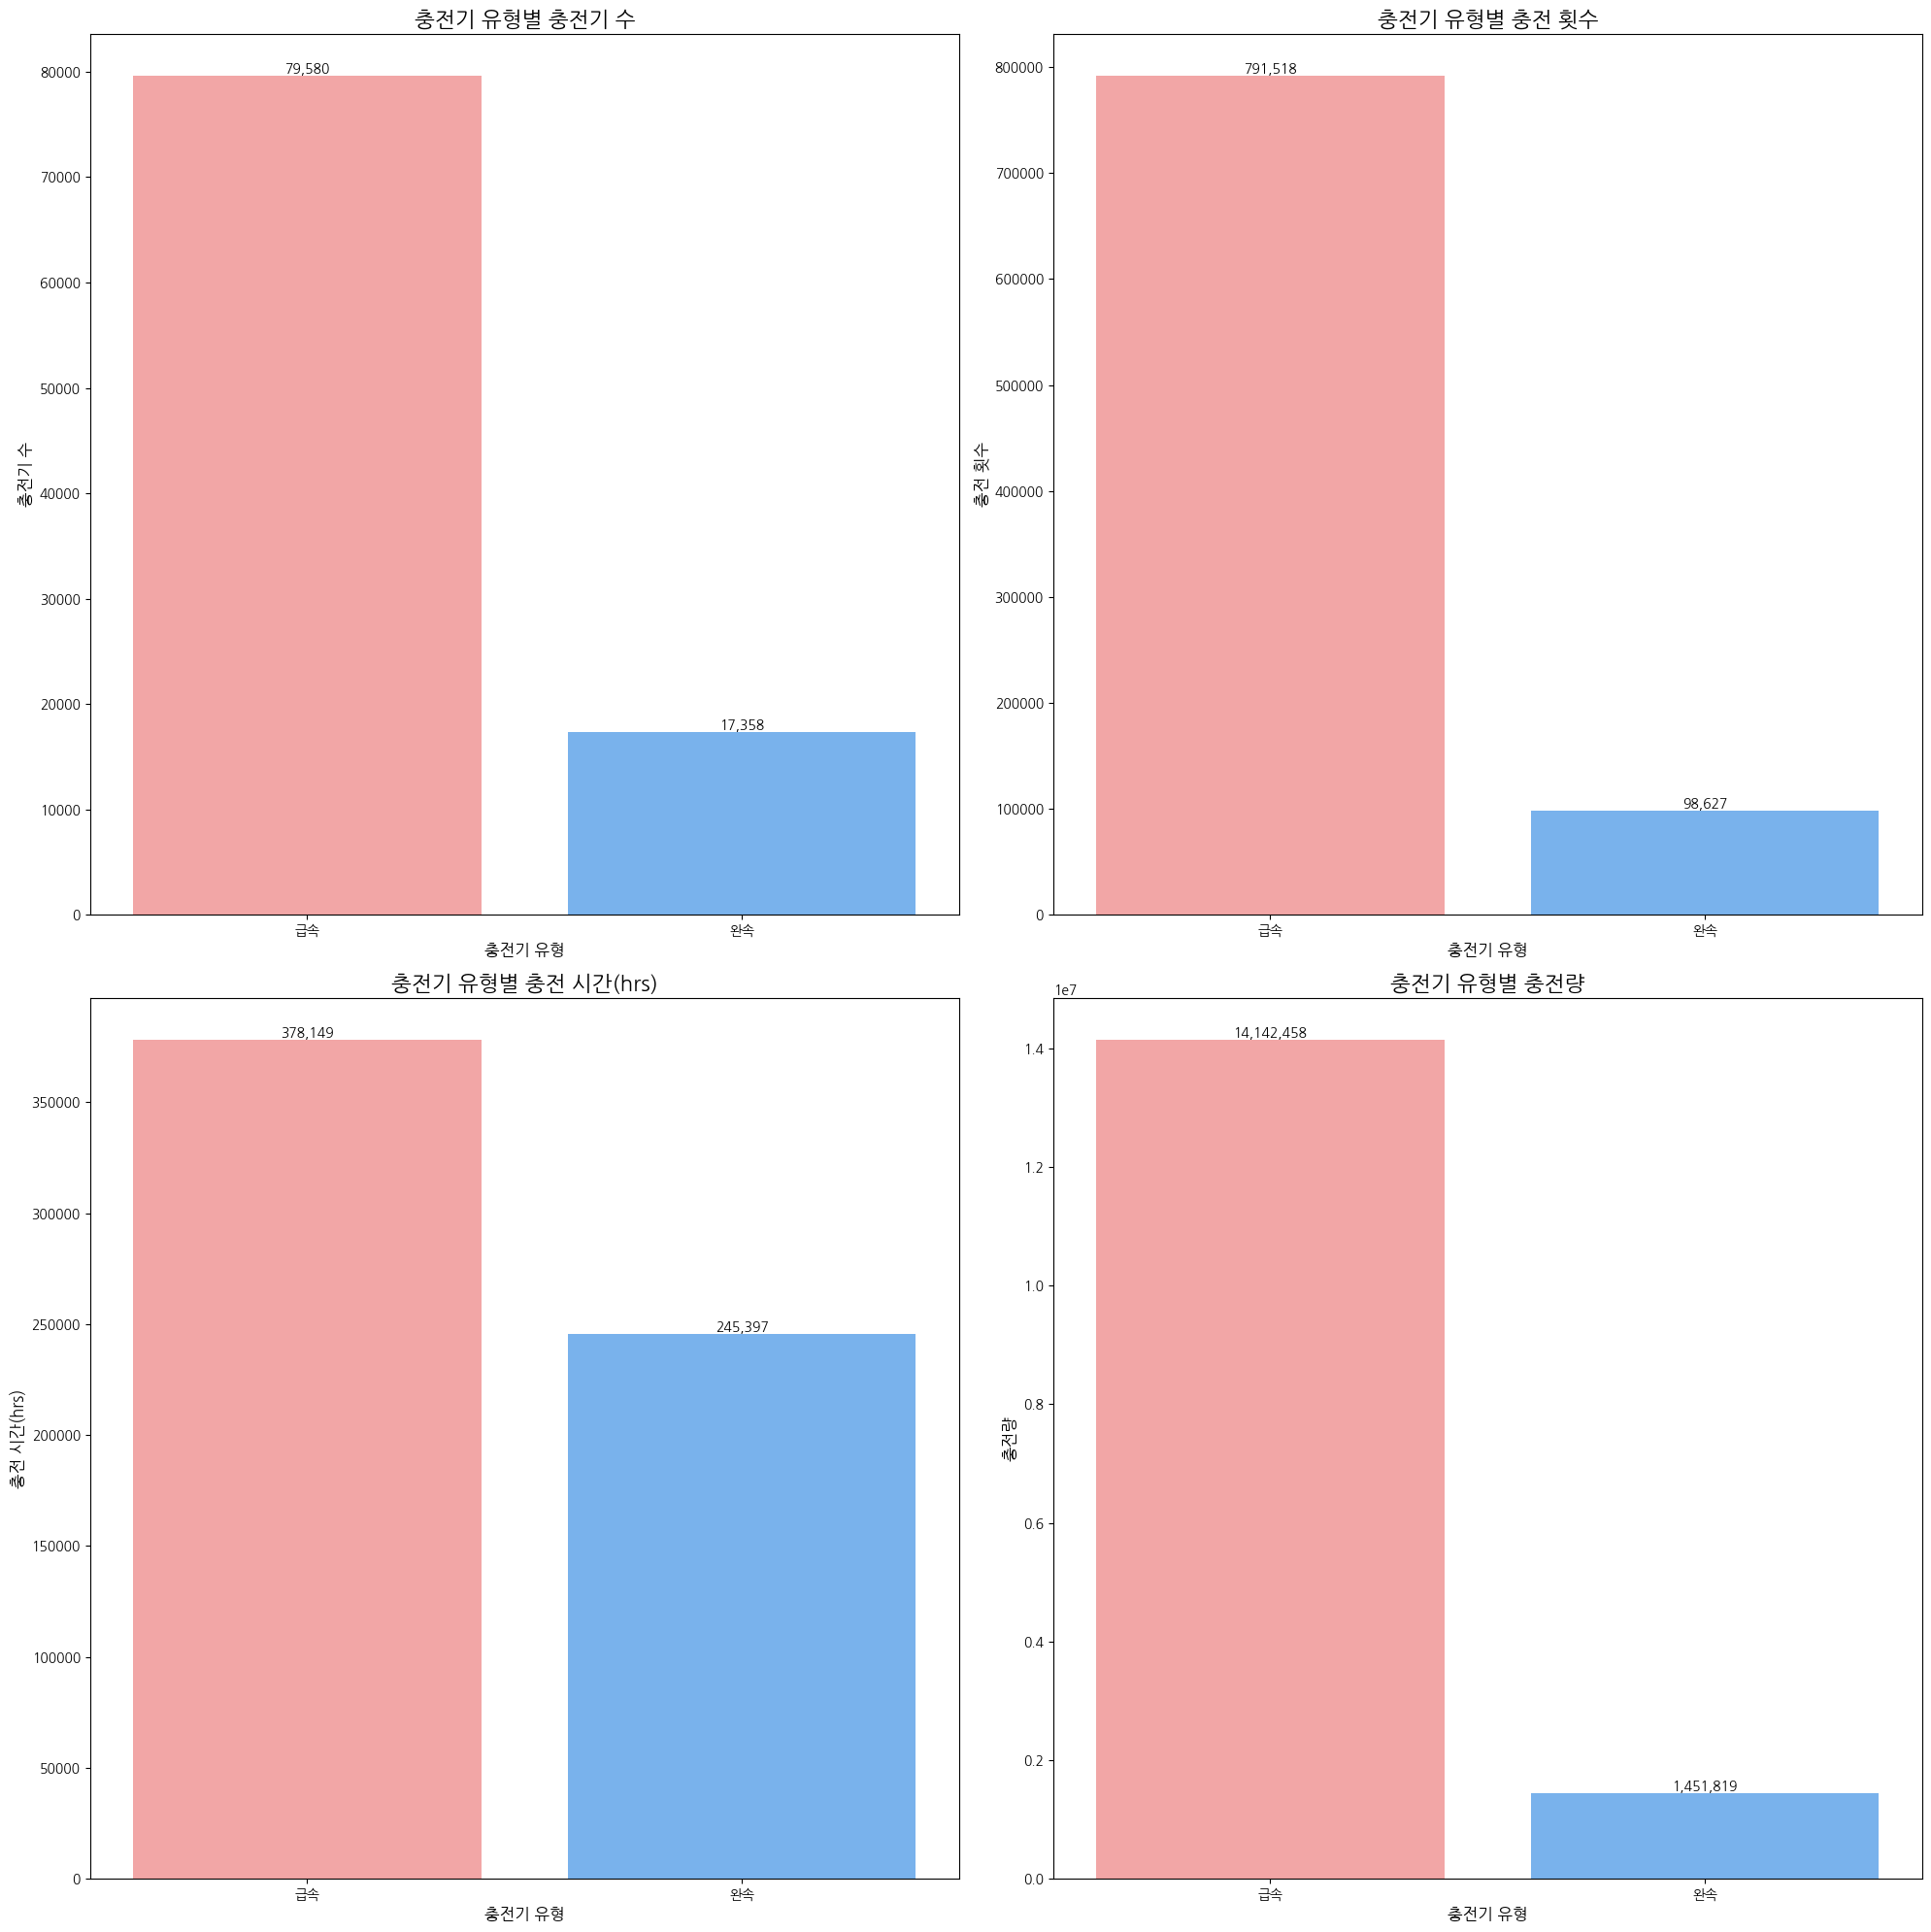

In [9]:
# 충전기 유형별 통계 계산
charger_type_stats = df_charging.groupby('충전기 유형').agg({
    '충전소 아이디': 'count',
    '충전 횟수': 'sum',
    '충전 시간(hrs)': 'sum',
    '충전량': 'sum'
}).rename(columns={'충전소 아이디': '충전기 수'})

# 충전기 유형별 통계 그래프 출력
plot_charger_type_stats(charger_type_stats)